# TN Motor Vehicle Registrations
- Acquired from TN Department of Revenue by [records request](https://www.tn.gov/revenue/about-us/contact-us/public-records-request.html) under Tennessee Public Records Act
- Notes:
    - Requested registration years 2018-2022

## Environment

In [14]:
# packages
import numpy as np
import pandas as pd
import time
import pyarrow

## Data Load

In [15]:
# tennesee mvr data

df = pd.read_parquet('data/tn_mvr/tn_mvr.parquet', engine='pyarrow')

print(df.shape)
print('df obs: ',f"{df.shape[0]:,d}")

(9831774, 13)
df obs:  9,831,774


In [16]:
# set dates dtype
df['title_issue_date'] = pd.to_datetime(df['title_issue_date'],format='%Y-%m-%d')
df['purchase_date'] = pd.to_datetime(df['purchase_date'],format='%Y-%m-%d', errors='coerce') # coerce errors to NaT


In [17]:
df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9831774 entries, 0 to 9831773
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   vin               string        
 1   price             Float32       
 2   odometer_type     category      
 3   mileage           Int32         
 4   county            category      
 5   zip               string        
 6   model_year        Int16         
 7   make              string        
 8   model             string        
 9   vehicle_type      category      
 10  new_used          category      
 11  title_issue_date  datetime64[ns]
 12  purchase_date     datetime64[ns]
dtypes: Float32(1), Int16(1), Int32(1), category(4), datetime64[ns](2), string(4)
memory usage: 609.5 MB


In [18]:
# filter for purchase years 2018-2022
df = df[df['purchase_date'].dt.year.isin([2018,2019,2020,2021,2022])]
df['purchase_date'].dt.year.value_counts()

2021    1963724
2019    1916741
2020    1882997
2018    1869620
2022    1675029
Name: purchase_date, dtype: int64

## Basic Data Info

In [19]:
df.nunique()

vin                 7179851
price                314678
odometer_type             5
mileage              260972
county                   97
zip                    5210
model_year              131
make                   8182
model                 23980
vehicle_type             16
new_used                  2
title_issue_date       1965
purchase_date          1826
dtype: int64

In [20]:
# data sample
df.sample(5).T

,8586112,1674374,7213520,8498092,2613260
vin,1FADP3F28GL290865,1FT8W2BT5MEC25480,1ZWFT61L3X5678812,3N1AB7AP4DL682010,1FTEX15N4RKA62577
price,0.0,66413.0,0.0,<NA>,500.0
odometer_type,0,0,1,0,9
mileage,44679,8,122966,152889,0
county,Shelby,Montgomery,Knox,State,Campbell
zip,38134,37010,37938,37088,37766
model_year,2016,2021,1999,2013,1994
make,FORD,FORD,MERC,NISS,FORD
model,FOC,F25,COU,SML,F15
vehicle_type,AUTO,TRUCK,AUTO,AUTO,TRUCK


In [21]:
# numeric
df.describe().round(decimals = 1)

,price,mileage,model_year
count,8976648.0,9308110.0,9308111.0
mean,2288266.9,40638.5,2010.6
std,2872721426.0,4521255.3,9.8
min,-7.0,-225699640.0,1005.0
25%,0.0,0.0,2005.0
50%,0.0,10.0,2013.0
75%,1150.0,44099.0,2018.0
max,8118003040256.0,2147483647.0,2890.0


In [22]:
# non-numeric
df.describe(include = ['object','category'])

,odometer_type,county,vehicle_type,new_used
count,9308111,9308111,9308111,9308111
unique,5,97,16,2
top,0,State,AUTO,U
freq,4917914,999492,6600359,7500723


In [23]:
# dates
df.describe(include = ['datetime'], datetime_is_numeric=True)

,title_issue_date,purchase_date
count,9308096,9308111
mean,2020-07-30 19:17:13.918002176,2020-06-10 20:32:35.104660992
min,1986-08-05 00:00:00,2018-01-01 00:00:00
25%,2019-05-17 00:00:00,2019-03-30 00:00:00
50%,2020-08-18 00:00:00,2020-06-15 00:00:00
75%,2021-10-14 00:00:00,2021-08-16 00:00:00
max,2022-12-30 00:00:00,2022-12-31 00:00:00


## Filter Used Autos and Trucks

In [24]:
# vehicle types
print(df['vehicle_type'].value_counts(dropna=False))

AUTO                    6600359
TRUCK                   1664998
FREIGHT/SEMI TRAILER     366578
MOTORCYCLE               282200
UTILITY (BOX/CARGO)      106541
CAMPER TRAILER            95165
OTHER                     68482
MOBILE HOME/HOUSE TR      47058
UTILITY (FLAT BED) T      40156
RECREATION/MOTOR HOM      18910
BUS - COMMERCIAL           7646
LIVESTOCK/HORSE TRAI       5180
WATERCRAFT TRAILER         2711
SCHOOL BUS                 2090
Multipurpose Vehicle         20
VAN                          17
Name: vehicle_type, dtype: int64


In [25]:
# filter to used only
print(f'all obs: {df.shape[0]:,d}')
df.drop(df[df['new_used'] == 'N'].index, inplace=True)
print(f'used only obs: {df.shape[0]:,d}')


all obs: 9,308,111
used only obs: 7,500,723


## VINs

Duplicate VINs need to be worked on

In [26]:
print('obs: {0:,d}'.format(df.shape[0]))
print('unique vins: {0:,d}'.format(df['vin'].unique().shape[0]))

obs: 7,500,723
unique vins: 5,390,223


## Prices

Have got some price issues
- Lots of missing with 0 filler
- Very high values

In [14]:
num = df.shape[0]
print('total obs: ',f"{num:,d}")

num = (df['price'] < 0.1).sum()
print('0 prices: ',f"{num:,d}")

num = (df['price'] > 10000).sum()
print('prices > 10,000: ',f"{num:,d}")

num = ((df['price'] > 0.1) & (df['price'] < 10000)).sum()
print('prices between: ',f"{num:,d}")

total obs:  7,290,817
0 prices:  3,972,161
prices > 10,000:  697,776
prices between:  2,279,048


In [29]:
df = df[df['price'] > 0.1]
df.shape

(3178162, 13)

<AxesSubplot:>

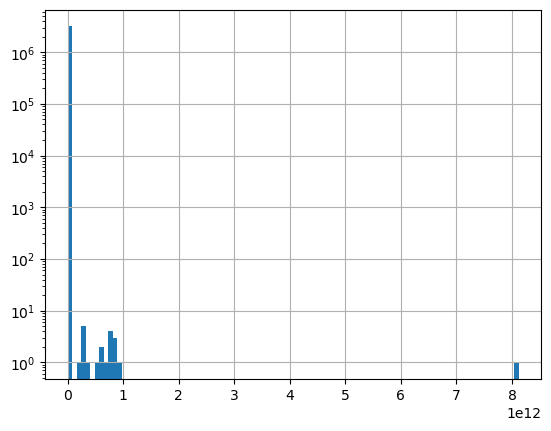

In [31]:
# price histogram on log scale
df['price'].hist(bins=100, log=True)

<AxesSubplot:>

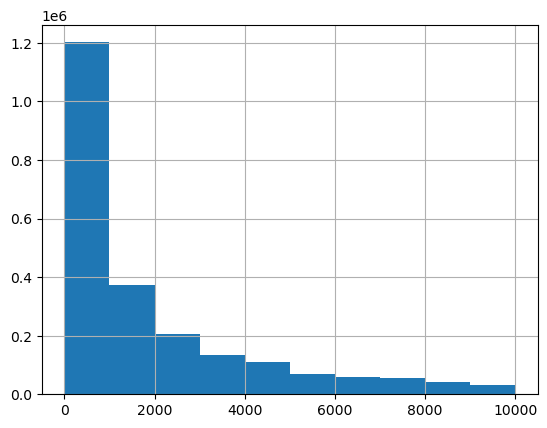

In [15]:
# hist prices between $0.1 and $10,000
df[((df['price'] > 0.1) & (df['price'] < 10000))]['price'].hist()

### High Prices

In [41]:
# count prices highter than 1,000,000
(df['price'] > 1000000).sum()

141

In [43]:
# drop prices higher than 1,000,000
df = df[df['price'] < 1000000]
df.shape

(3178021, 13)

In [16]:
pd.set_option('display.max_rows', 100)

In [44]:
df.sort_values(by='price', ascending=False).head(50).reset_index()

,index,vin,price,odometer_type,mileage,county,zip,model_year,make,model,vehicle_type,new_used,title_issue_date,purchase_date
0,4508766,2GNFLEEK8F6256225,950000.0,0,129285,Washington,37663,2015,CHEV,EQU,AUTO,U,2021-11-04,2020-10-07
1,7863391,CSX2306,935199.0,1,0,State,37664,1964,ACGC,COB,AUTO,U,2022-02-09,2018-06-19
2,8505141,5GRGN23U06H112364,930984.0,0,220986,Madison,38305,2006,HUMM,HU2,AUTO,U,2021-04-05,2021-03-06
3,4220052,2FAGP9CW6HH200070,930000.0,0,927,Maury,38401,2017,FORD,GT,AUTO,U,2020-09-23,2020-09-14
4,7959043,2LMDU88C69BJ05009,918900.0,0,138020,Bedford,37160,2009,LINC,MKX,AUTO,U,2018-09-20,2018-08-31
5,8766957,WLFA51BZ3HEZZ0044,907500.0,0,43878,Sevier,37864,2017,LIEB,LTM,OTHER,U,2020-09-29,2020-06-30
6,7549925,1F66F5DYXG0A10943,900025.1875,0,15196,Trousdale,37031,2016,FORD,FBN,RECREATION/MOTOR HOM,U,2020-12-17,2020-11-20
7,6441446,JN8AS5MT9BW184259,898800.0,0,114908,Knox,37931,2011,NISS,RGE,AUTO,U,2019-05-08,2019-04-27
8,2472553,1J4NF1GBXBD274443,890000.0,0,80983,Washington,37615,2011,JEEP,PAT,AUTO,U,2018-06-13,2018-05-27
9,7225792,WP0CA29805L001427,872500.0,1,0,Williamson,37027,2005,PORS,CAR,AUTO,U,2021-09-13,2021-02-10


In [45]:
# proportion of prices greater than 100,000 by county
df[df['price'] > 100000]['county'].value_counts(normalize=True)

Davidson      0.107249
Williamson    0.084192
Knox          0.078777
Shelby        0.071092
Hamilton      0.048908
                ...   
Decatur       0.000524
Hancock       0.000175
Stewart       0.000175
Perry         0.000175
VAM           0.000000
Name: county, Length: 97, dtype: float64

<AxesSubplot:>

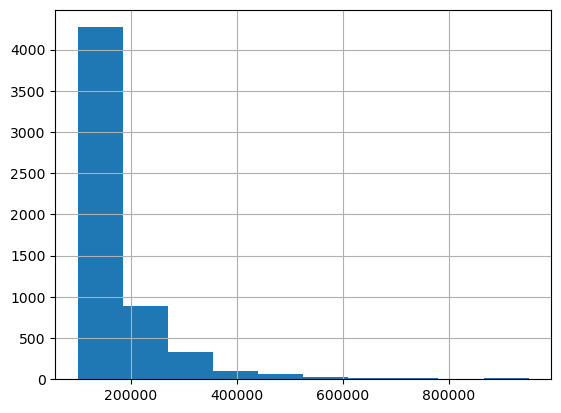

In [48]:
# histogram of prices over 100,000
df[df['price'] > 100000]['price'].hist()

In [50]:
# sample of records with prices over 100,000
df[df['price'] > 100000].sample(10).T

,2616135,6160418,1121911,6284030,8098285,8817535,3202161,1336800,4483137,8039246
vin,1RF43561593049236,SCFHMDBS0HGF05752,1CYDCV5838T048296,WP0AD2A96FS166439,SCFRMFEV0LGL08396,4UZFCGCY3HCJH9678,2NP3LJ0XXNM778655,1FVAC4DV2CHBR5704,1NKZX4TX5JJ198216,4UZACGFE2KCKX9018
price,174099.0,110000.0,375000.0,137334.0,148999.0,223500.0,155000.0,130000.0,155000.0,160367.0
odometer_type,0,0,1,0,0,1,0,0,0,1
mileage,53904,1395,0,20650,17251,0,28954,96046,158000,0
county,Rutherford,Shelby,Knox,Davidson,Madison,Hawkins,Shelby,Henderson,Maury,Hawkins
zip,37127,38139,37920,37189,38305,37642,38137,38351,38401,37857
model_year,2009,2017,2008,2015,2020,2018,2022,2012,2018,2019
make,MOCO,ASTO,ATLA,PORS,ASTO,REVC,PTRB,FRHT,KW,FRHT
model,CAM,RPD,1CY,911,DB1,DIP,348,M2,T88,4UZ
vehicle_type,RECREATION/MOTOR HOM,AUTO,TRUCK,AUTO,AUTO,RECREATION/MOTOR HOM,TRUCK,TRUCK,TRUCK,RECREATION/MOTOR HOM


### Distributions by County

In [46]:
# mean prices by county

nums = df.groupby('county')['price'].mean().sort_values(ascending=False)
index = nums.index

for i in range(len(nums)):
    print("{}: ${:0,.2f}".format(index[i],nums[i]))

Madison: $13,903.82
Fayette: $13,529.55
Williamson: $13,483.94
Anderson: $13,142.24
Henry: $12,625.55
Hardin: $12,491.07
Tipton: $12,334.61
Gibson: $11,846.14
Dyer: $11,512.04
Washington: $11,253.05
Bedford: $11,224.97
Hardeman: $11,064.03
Roane: $10,476.48
Henderson: $10,243.47
Chester: $10,226.43
Lauderdale: $10,013.31
Davidson: $9,963.19
Crockett: $9,794.11
McNairy: $9,698.63
Carroll: $9,474.59
Hamilton: $9,203.95
Cheatham: $9,195.38
Hamblen: $8,438.50
Wayne: $8,223.95
Lake: $8,083.94
Unicoi: $7,997.24
Sumner: $7,979.42
Claiborne: $7,936.72
Houston: $7,826.12
Trousdale: $7,791.85
Polk: $7,742.47
Bledsoe: $7,722.40
Loudon: $7,630.41
Knox: $7,484.78
Dekalb: $7,446.54
Moore: $7,353.46
Pickett: $7,319.48
Weakley: $7,280.13
Macon: $7,261.41
Lincoln: $7,131.61
Humphreys: $7,111.75
Fentress: $7,098.18
Montgomery: $7,081.01
Wilson: $6,970.87
Smith: $6,931.40
Meigs: $6,779.58
Bradley: $6,727.68
Shelby: $6,651.51
Campbell: $6,594.55
Obion: $6,518.64
Cumberland: $6,390.90
Maury: $6,317.56
Sull

In [47]:
# median prices by county

nums = df.groupby('county')['price'].median().sort_values(ascending=False)
index = nums.index

for i in range(len(nums)):
    print("{}: ${:0,.2f}".format(index[i],nums[i]))

Madison: $9,995.00
Anderson: $6,707.00
Henry: $6,239.00
Dyer: $6,132.62
Hardin: $6,100.00
Gibson: $6,000.00
Fayette: $6,000.00
Washington: $5,800.00
Tipton: $5,800.00
Bedford: $5,204.52
Hardeman: $5,000.00
Williamson: $4,500.00
McNairy: $4,100.00
Crockett: $4,000.00
Lauderdale: $4,000.00
Henderson: $3,875.00
Chester: $3,750.00
Cheatham: $3,500.00
Carroll: $3,500.00
Roane: $3,000.00
Hamilton: $3,000.00
Davidson: $2,999.00
Wayne: $2,750.00
Unicoi: $2,700.00
Houston: $2,500.00
Moore: $2,500.00
Dekalb: $2,500.00
Humphreys: $2,500.00
Sumner: $2,500.00
Macon: $2,500.00
Trousdale: $2,491.90
Hamblen: $2,395.00
Fentress: $2,300.00
Montgomery: $2,000.00
Weakley: $2,000.00
Polk: $2,000.00
Bradley: $2,000.00
Lake: $2,000.00
Lincoln: $2,000.00
Clay: $2,000.00
Pickett: $2,000.00
Shelby: $2,000.00
Loudon: $1,800.00
Jackson: $1,750.00
Rutherford: $1,700.00
Smith: $1,700.00
McMinn: $1,700.00
Robertson: $1,700.00
Meigs: $1,500.00
Obion: $1,500.00
Overton: $1,500.00
Sullivan: $1,500.00
Perry: $1,500.00
W

In [36]:
groups = df.groupby('county')

for name, group in groups:
    print(name)
    print(group['price'].describe().round(decimals = 1))

Anderson
count        71172.0
mean         14614.0
std         375396.4
min              1.0
25%            800.0
50%           6713.8
75%          21599.0
max      100000000.0
Name: price, dtype: Float64
Bedford
count      52909.0
mean       11696.0
std        43175.0
min            1.0
25%         1000.0
50%         5215.0
75%        16881.0
max      4521578.0
Name: price, dtype: Float64
Benton
count     11154.0
mean       4510.8
std       10100.5
min          40.0
25%         300.0
50%         900.0
75%        3800.0
max      394500.0
Name: price, dtype: Float64
Bledsoe
count       9037.0
mean        7887.6
std        20213.8
min           25.0
25%          500.0
50%         1500.0
75%         9500.0
max      1500272.0
Name: price, dtype: Float64
Blount
count      59057.0
mean        6259.0
std        14957.7
min            1.0
25%          500.0
50%         1500.0
75%         5400.0
max      1625000.0
Name: price, dtype: Float64
Bradley
count      52177.0
mean        6911.9
std    

## The Rest

In [19]:
# null counts
pd.DataFrame({'count':df.isna().sum()
             ,'percent':(df.isna().sum()/df.shape[0]).round(decimals=2)}
    ).sort_values(by='count', ascending=False)

,count,percent
price,323622,0.04
title_issue_date,532,0.00
purchase_date,331,0.00
model,215,0.00
vin,0,0.00
odometer_type,0,0.00
mileage,0,0.00
county,0,0.00
zip,0,0.00
model_year,0,0.00


In [20]:
# 0 or filler counts